<DIV ALIGN=CENTER>
# IOWA HOUSING PREDICTION
## BY Xichen Huang
## January 26, 2017
</DIV>
-----

First to load the necessary packages and the data

In [7]:
library(moments)  # skewness
library(corrplot)  # corrplot

train = read.csv('./train.csv')
test = read.csv('./test.csv')

dim(train)  # dimension of the training data

#str(train)  # structure of the training data

data.type = sapply(train[, -c(1, 81)], class)  # table the data type
table(data.type)
?c
dim(test)  # dimension of the test data

#str(test)  # structure of the test data


[1] 1460   81

data.type
 factor integer 
     43      36 

[1] 1459   80

In [8]:

# apply function: use the given function (is.na) for each column (use 2 for column, and use 1 for row) 
# in the matrix train[, -c(1, 81)].
numNA = colSums(apply(train[, -c(1, 81)], 2, is.na))
number_of_missing = numNA[which(numNA != 0)]  # number of NA's
data_type = sapply(train[,names(which(numNA != 0))], class)  # type of data
cbind(number_of_missing, data_type)

drops = c("Alley", "PoolQC", "Fence", "MiscFeature")
train = train[ , !(names(train) %in% drops)]
test = test[ , !(names(test) %in% drops)]


,number_of_missing,data_type
LotFrontage,259,integer
Alley,1369,factor
MasVnrType,8,factor
MasVnrArea,8,integer
BsmtQual,37,factor
BsmtCond,37,factor
BsmtExposure,38,factor
BsmtFinType1,37,factor
BsmtFinType2,38,factor
Electrical,1,factor


In [9]:

#For the rest of the categorical variables, we can complete the missing values by treating them as a new level.
data.type = sapply(train[, -c(1, ncol(train))], class)  # as we've removed 4 variables
cat_var = names(train)[which(c(NA, data.type, NA) == 'factor')]  # categorical variables
numeric_var =  names(train)[which(c(NA, data.type, NA) == 'integer')]  # continuous variables
for (j in cat_var){
  train[, j] = addNA(train[, j])  # addNA treat the NA's as a new level called '<NA>'
  test[, j] = addNA(test[, j])
}

tempVar = c('LotFrontage', 'MasVnrArea', 'GarageYrBlt')
for (j in tempVar){
  na.id = is.na(train[, j])  # binary indicator: NA (1) or not (0)
  tempMedian = median(train[, j], na.rm = TRUE)  # find the median
  train[which(na.id), j] = tempMedian
  train[, paste(j, 'NAInd', sep = '_')] = as.numeric(na.id)  # create a new column
}

for (j in numeric_var){
  na.id = is.na(test[, j])
  if (!any(na.id)){
    next
  }
  test[which(na.id), j] = median(train[, j])
}



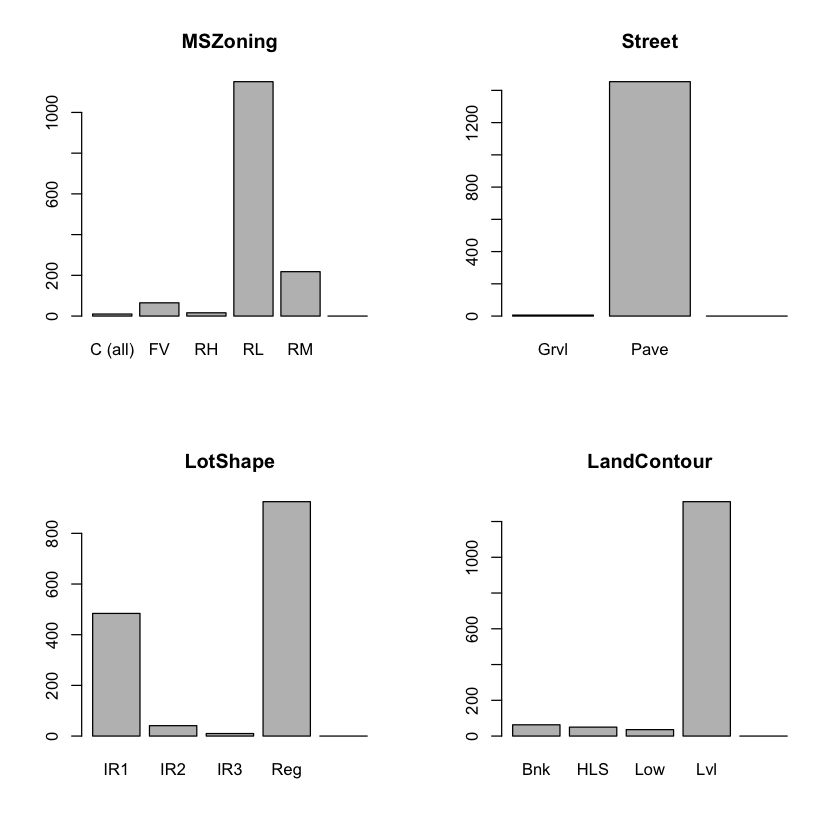

In [23]:
# Exploratory Data Analysis
#The followings are the bar-plot of the categorical variables:
par(mfrow = c(2, 2))  # set the layout of the plots
for(j in 1:4){
  barplot(table(train[, cat_var[j]]), main = cat_var[j])
}

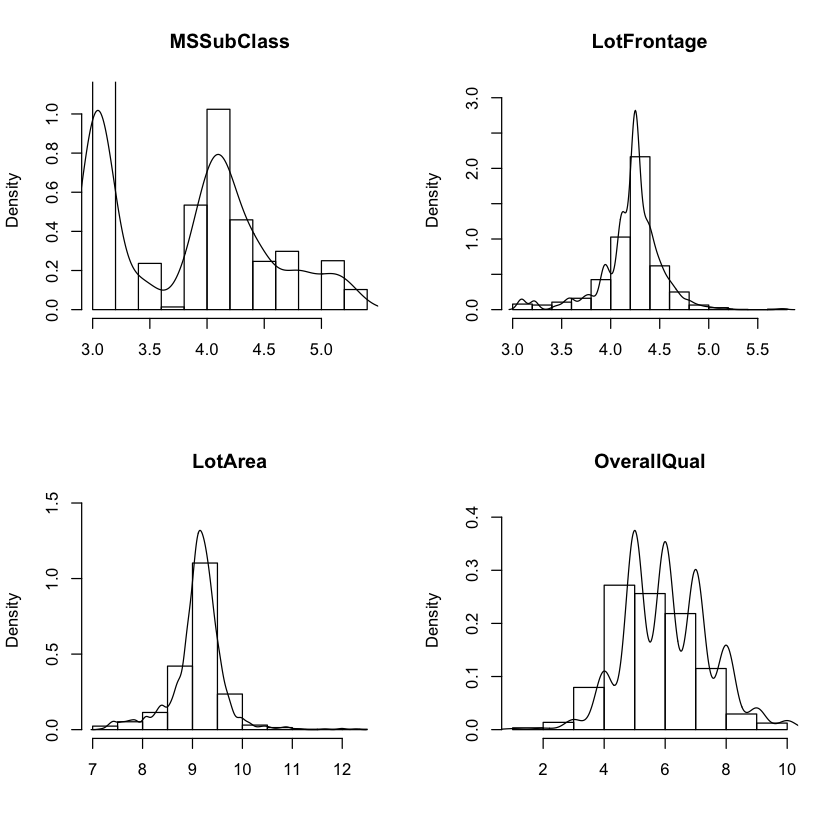

In [24]:

#The last bar in each plot is the number of NA levels.
#Histogram and density plots of numerical variables:
par(mfrow = c(2, 2))
for(j in 1:4){
  d = density(train[, numeric_var[j]])
  hist(train[, numeric_var[j]], main = numeric_var[j], xlab = '', prob = TRUE, ylim = c(0, max(d$y) * 1.1))
  lines(d)
}


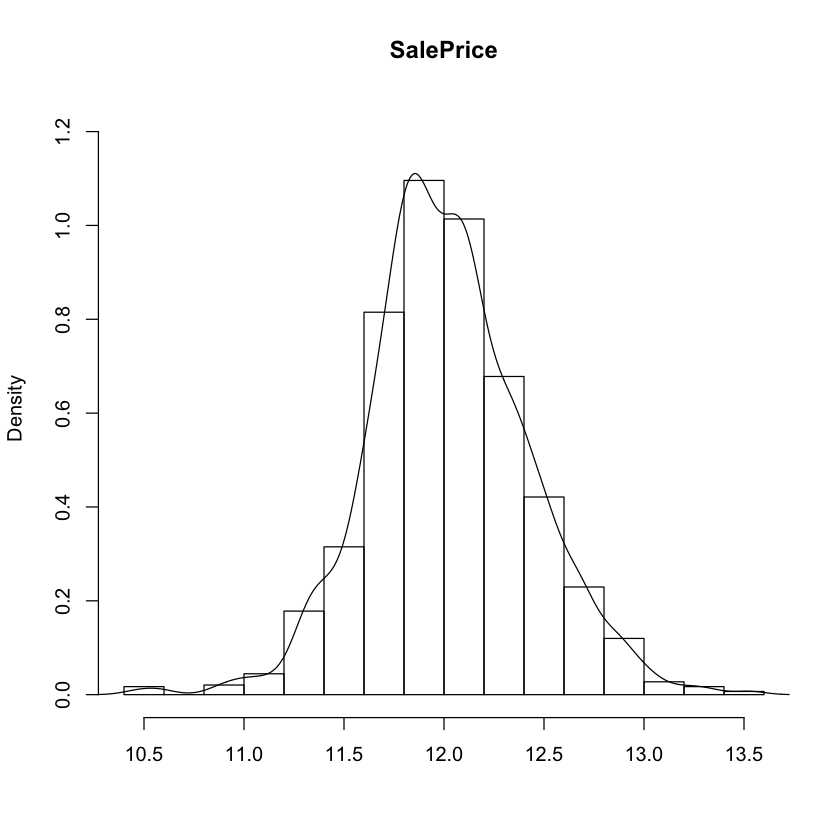

In [25]:
# We can see that some of the numerical variables have extreme values, and are skewed to the right.
#Similarly, we plot the histogram and density estimation of the response variable, “SalePrice”. The data is also skewed to the right.
d = density(train[, 'SalePrice'])
hist(train[, 'SalePrice'], main = 'SalePrice', xlab = '', prob = TRUE, ylim = c(0, max(d$y) * 1.1))
lines(d)

In [11]:
# Before we move on, we take the log-transformation for the response and the numerical featuers, which is one common approach used 
# in price/counts variables, and can alleviate the skewness.
# transform SalePrice target to log form
train$SalePrice <- log(train$SalePrice + 1)

# for numeric feature with excessive skewness, perform log transformation
# determine skew for each numeric feature
skewed_feats = sapply(train[, numeric_var], skewness)
# only transform features that exceed a threshold = 0.75 for skewness
skewed_feats = numeric_var[which(skewed_feats > 0.75)]
for(j in skewed_feats) {
  train[, j] = log(train[, j] + 1)
  test[, j] = log(test[, j] + 1)
}

[1] "LotFrontage"  "LotArea"      "OverallQual"  "YearBuilt"    "YearRemodAdd"
 [6] "MasVnrArea"   "TotalBsmtSF"  "X1stFlrSF"    "GrLivArea"    "FullBath"    
[11] "HalfBath"     "TotRmsAbvGrd" "Fireplaces"   "GarageYrBlt"  "GarageCars"  
[16] "GarageArea"   "WoodDeckSF"   "OpenPorchSF"

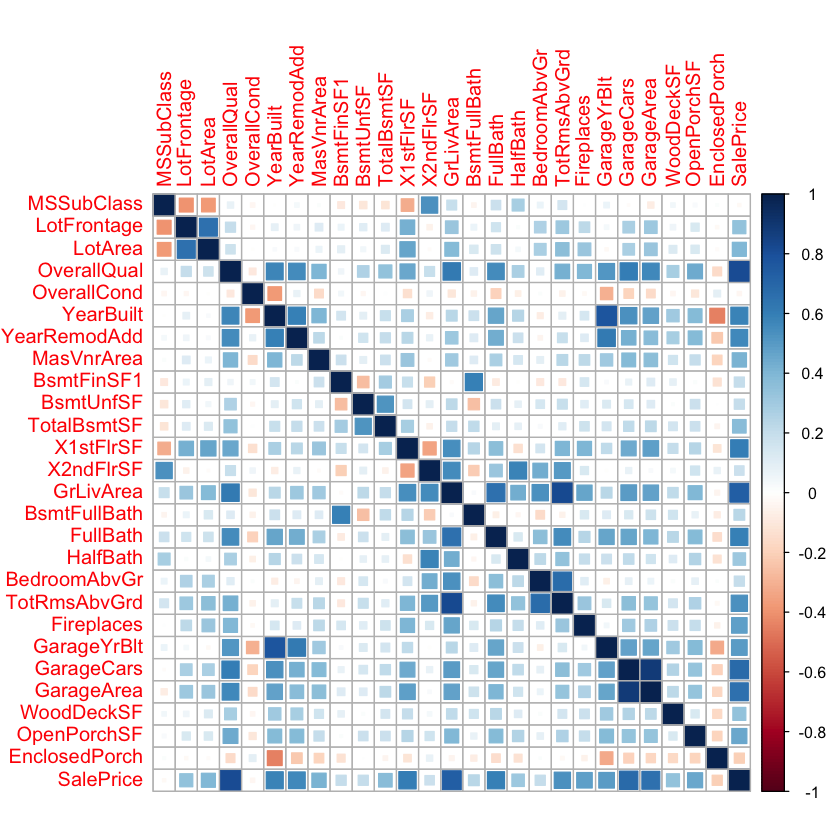

In [12]:
# Next, we explore the correlation of the response with the numerical features.
correlations = cor(train[, c(numeric_var, 'SalePrice')])  # correlation matrix
# for those relatively large correlations (> 0.3)
row_indic = apply(correlations, 1, function(x) sum(abs(x) > 0.3) > 1)
correlations = correlations[row_indic, row_indic]
corrplot(correlations, method = "square")

# record those with very large correlation (> 0.6)
highCor = which(abs(correlations[, ncol(correlations)]) > 0.3)
highCor = highCor[-length(highCor)]
names(highCor)

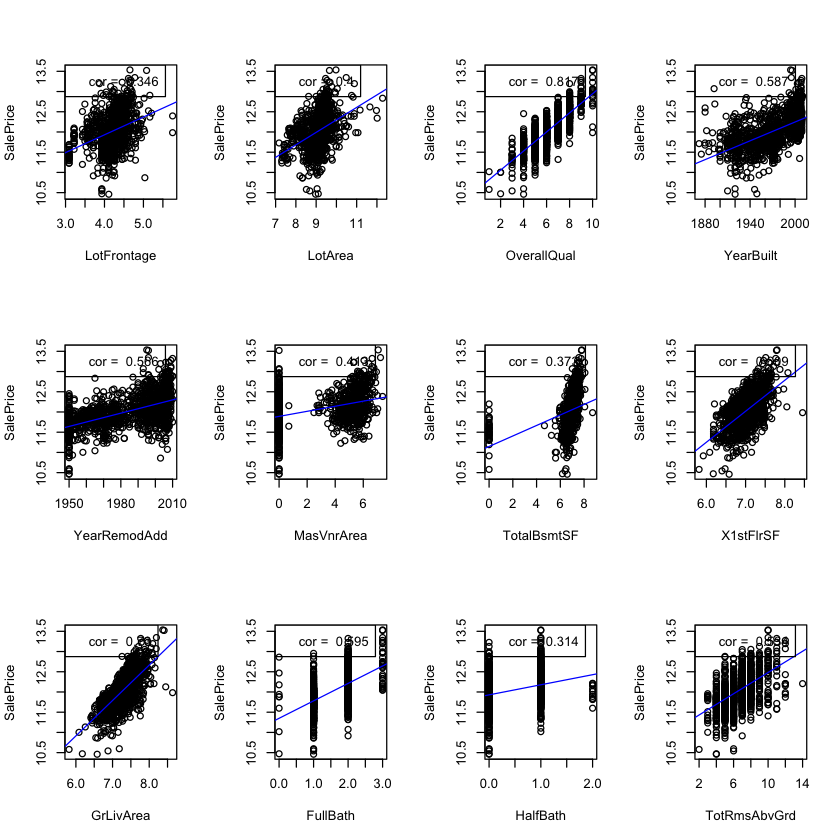

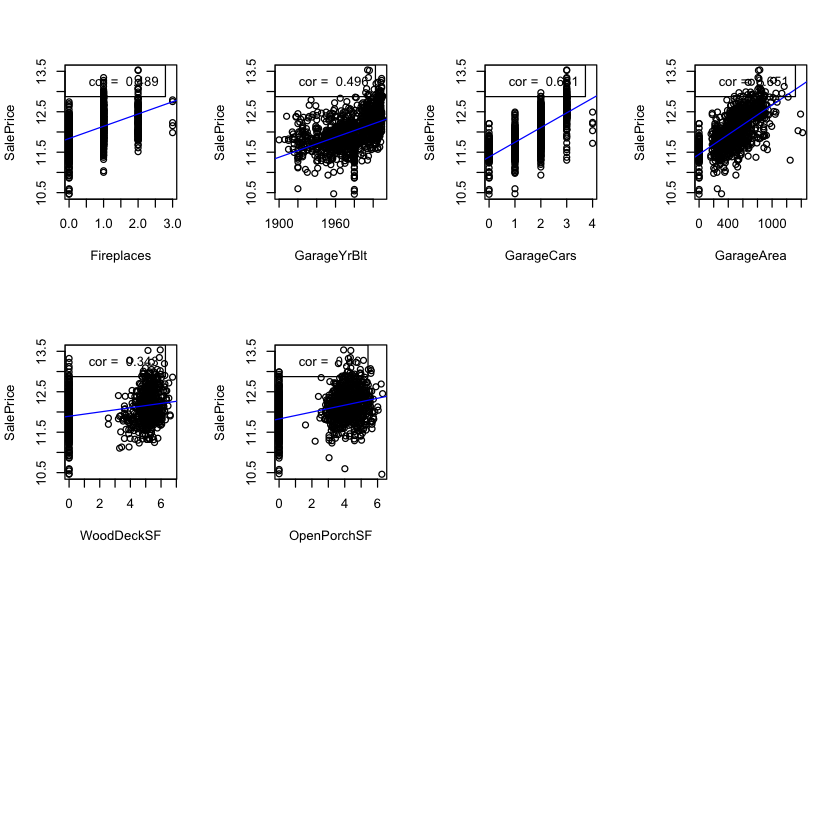

In [22]:
# Finally, we plot the variable versus SalePrice one by one:
par(mfrow = c(3,4))
for (j in 1:length(highCor)){
  plot(train[, names(highCor)[j]], train[, 'SalePrice'], xlab = names(highCor)[j], ylab = 'SalePrice')
  tempModel = lm(SalePrice ~ ., data = train[, c(names(highCor)[j], 'SalePrice')])
  abline(tempModel, col = 'blue')
  legend('topleft', legend = paste('cor = ', round(correlations[highCor[j], ncol(correlations)], 3)))
}

In [18]:
#  A Simple Linear Regression Model
# It seems that the five variales, OverallQual, X1stFlrSF, GrLivArea, GarageCars, GarageArea, has high 
# correlation with SalePrice. So we build a simple multiple regression with these variables:
mlr = lm(SalePrice ~ ., data = train[, c(names(highCor), 'SalePrice')])

# Then do prediction. Remember to convert the prediction to the original scale.
yHat = predict(mlr, newdata = test)
yHat = exp(yHat) - 1
head(yHat)

1        2        3        4        5        6 
118590.7 154810.0 183725.5 193956.4 190812.9 185511.9

In [19]:
#Finally, write the prediction to the submission file. You need to download the ‘sample_submission.csv’ file in order to use the following code.
submission = read.csv('./sample_submission.csv')
submission$SalePrice = yHat
write.table(submission, 'simple_model_temp.csv', row.names = FALSE, sep = ',')